In [1]:
# hide pakcage non critical warnings

import warnings

warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

import scipy.io as sio

import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.nn.init as init

from custom_data import DCCPT_data

from config import cfg, get_data_dir, get_output_dir, AverageMeter, remove_files_in_dir

from tensorboard_logger import Logger

import os
import random
import pickle
import numpy as np

import data_params as dp

In [3]:
import devkit.api as dk

In [4]:
datadir = get_data_dir("mnist")
outputdir = get_output_dir("mnist")

In [5]:
datadir

'/Users/jasper/dev/DCC/data/mnist'

In [6]:
datadir

'/Users/jasper/dev/DCC/data/mnist'

In [7]:
with open(os.path.join(datadir, "pretrained.pkl"), 'rb') as f:
    pretrain_info = pickle.load(f)

In [8]:
pretrain_info.keys()

dict_keys(['labels', 'Z', 'data'])

In [9]:
print(pretrain_info['data'].shape, pretrain_info['Z'].shape, pretrain_info['labels'].shape)

(70000, 784) (70000, 10) (70000,)


In [10]:
y_gt_pretrain = pretrain_info['labels']
y_gt_pretrain.shape

(70000,)

In [11]:
X = pretrain_info['data']
X.shape

(70000, 784)

In [12]:
Z = pretrain_info['Z']
Z.shape

(70000, 10)

In [13]:
ixs_selected = np.random.choice(len(Z),10000, replace=False)

# viz raw data [X]

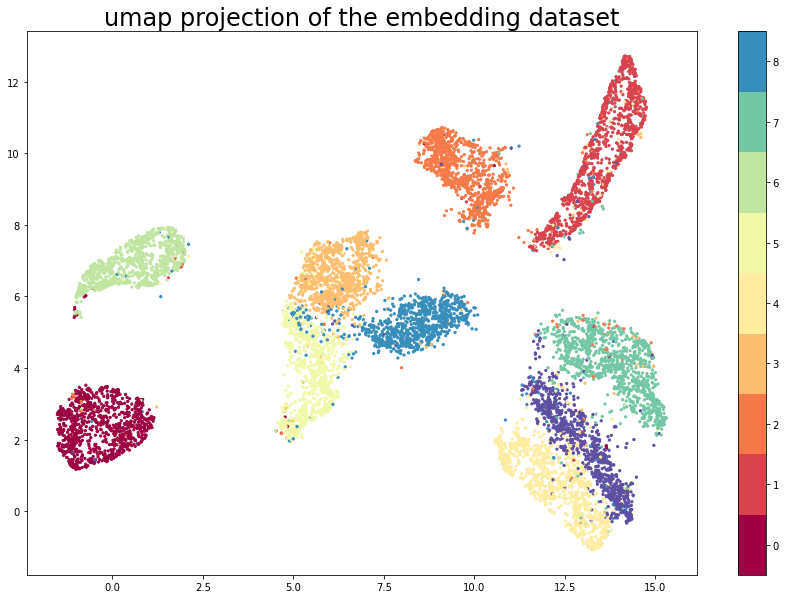

In [107]:
dk.data_viz(X[ixs_selected], y_gt_pretrain[ixs_selected])

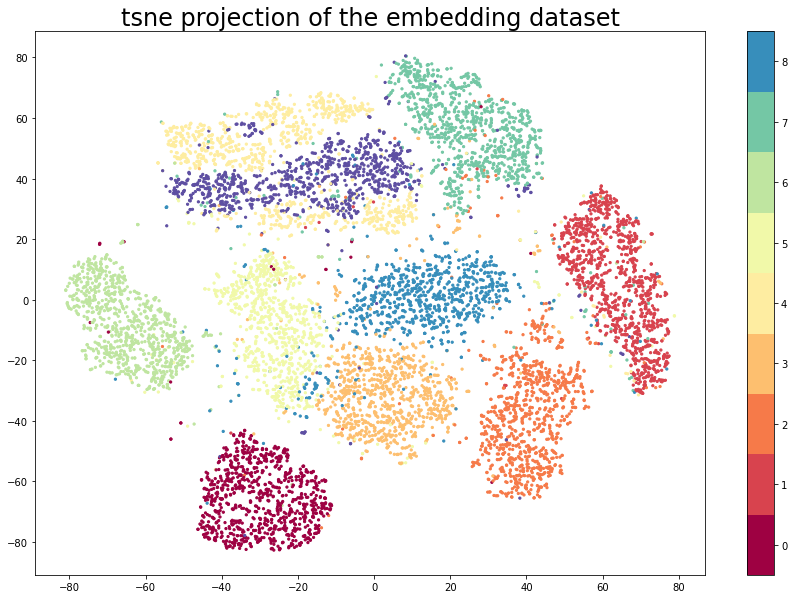

In [108]:
dk.data_viz(X[ixs_selected], y_gt_pretrain[ixs_selected], method='tsne')

# viz embedding of sdae [Z]

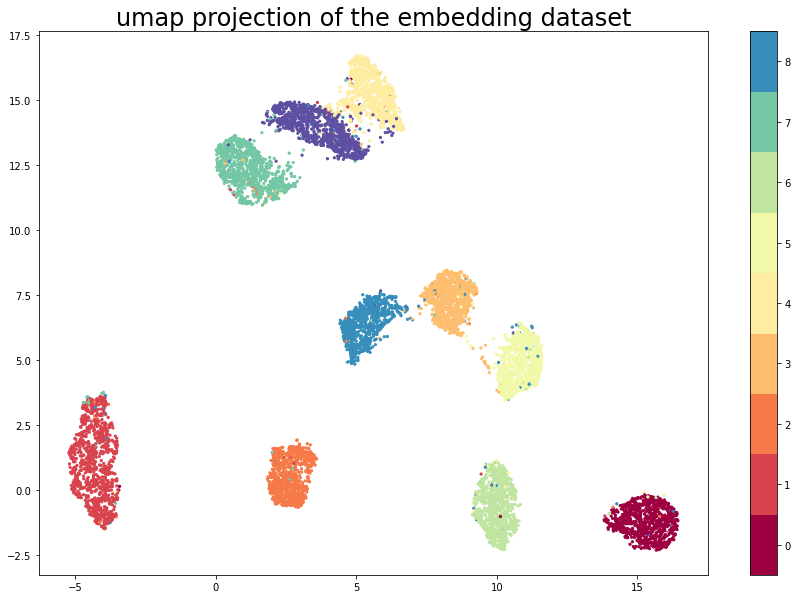

In [93]:
dk.data_viz(Z[ixs_selected], y_gt_pretrain[ixs_selected])

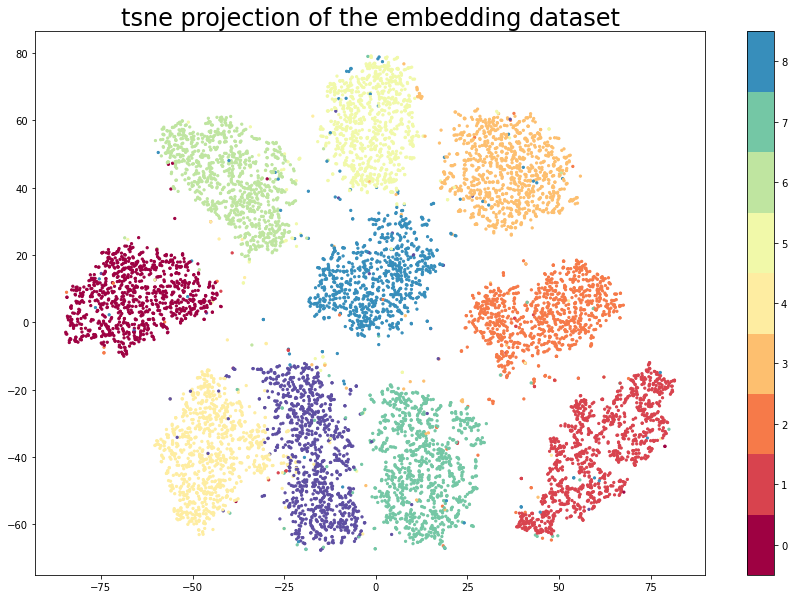

In [94]:
dk.data_viz(Z[ixs_selected], y_gt_pretrain[ixs_selected], method='tsne')

# viz embedding of dcc [U]

## calculate U from checkpoint

In [14]:
from DCCLoss import DCCWeightedELoss, DCCLoss

In [15]:
datadir

'/Users/jasper/dev/DCC/data/mnist'

In [16]:
dcc_ckp = torch.load(os.path.join(datadir, "results/FTcheckpoint_100.pth.tar"))

In [17]:
dcc_ckp.keys()

dict_keys(['epoch', 'state_dict', 'criterion_state_dict', 'optimizer', 'sigma1', 'sigma2', 'lambda', 'delta', 'delta1', 'delta2'])

In [18]:
Z.shape

(70000, 10)

In [19]:
criterion2 = DCCLoss(Z.shape[0], Z.shape[1], Z, size_average=True)

In [20]:
criterion2.load_state_dict(dcc_ckp['criterion_state_dict'])

<All keys matched successfully>

In [21]:
U = criterion2.U.data.cpu().numpy()

In [136]:
U.shape[-1]

10

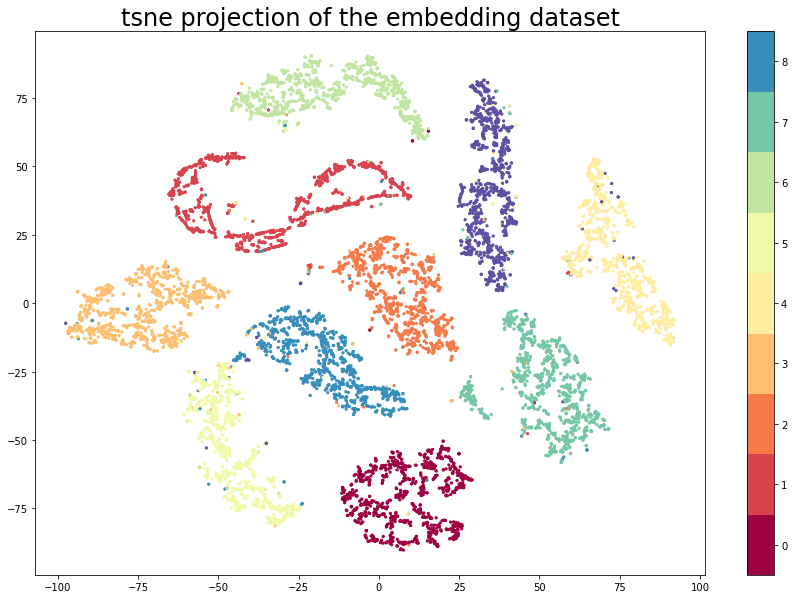

In [135]:
dk.data_viz(X=U[ixs_selected], y=y_gt[ixs_selected], method='tsne')

## get the U from final output

In [22]:
dcc_res = sio.loadmat(os.path.join(datadir, "results/features.mat"))

In [23]:
dcc_res.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Z', 'U', 'gtlabels', 'w', 'cluster'])

In [24]:
U_final = dcc_res['U']

In [25]:
y_gt = dcc_res['gtlabels'].flatten()

In [26]:
y_pred = dcc_res['cluster'].flatten()

In [27]:
y_pred.shape

(70000,)

In [28]:
assert (y_gt == y_gt_pretrain).all()

In [29]:
print(U_final.shape, y_gt.shape)

(70000, 10) (70000,)


## viz U

### umap

In [169]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

11


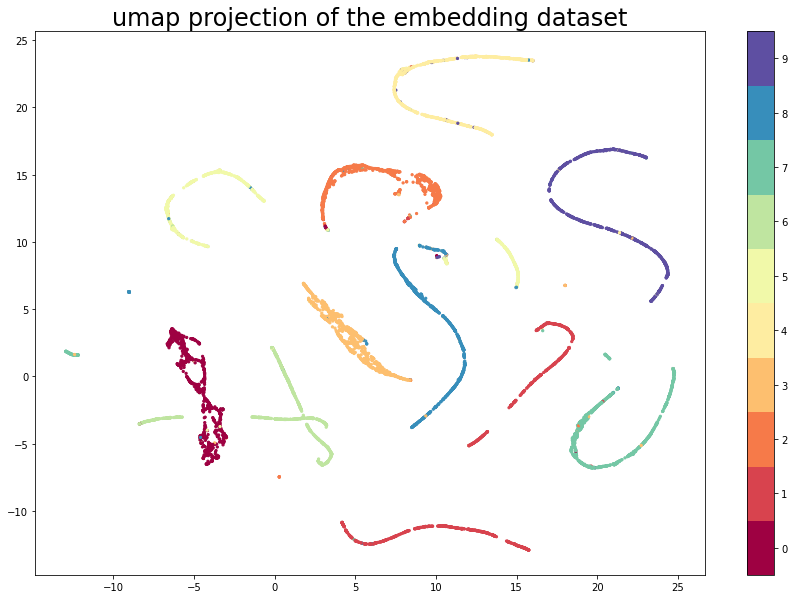

In [172]:
dk.data_viz(X=U_final[ixs_selected], y=y_gt[ixs_selected], method='umap')

### tsne

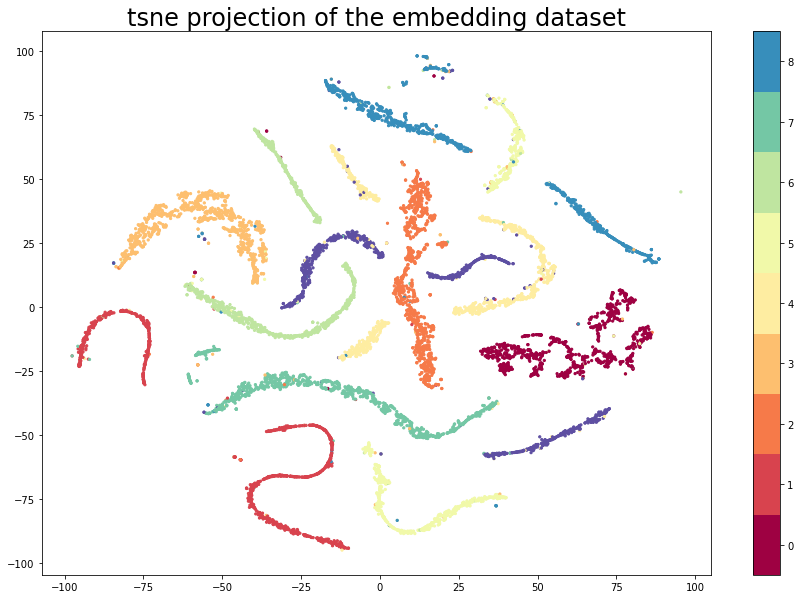

In [128]:
dk.data_viz(X=U_final[ixs_selected], y=y_gt[ixs_selected], method='tsne')

# viz images by cluster

In [166]:
def clustering_accuracy(gtlabels, labels):
    from scipy.optimize import linear_sum_assignment
    cost_matrix = []
    categories = np.unique(gtlabels)
    nr = np.amax(labels) + 1
    for i in np.arange(len(categories)):
        cost_matrix.append(np.bincount(labels[gtlabels == categories[i]], minlength=nr))
    cost_matrix = np.asarray(cost_matrix).T
    row_ind, col_ind = linear_sum_assignment(np.max(cost_matrix) - cost_matrix)

    return float(cost_matrix[row_ind, col_ind].sum()) / len(gtlabels)

In [167]:
clustering_accuracy(gtlabels=y_gt, labels=y_pred)

0.8599428571428571

In [163]:
plt.imshow??

In [31]:
import pandas as pd

In [32]:
lst_top_classes = pd.Series(y_pred).value_counts().index.tolist()[:10]
lst_bottom_classes = pd.Series(y_pred).value_counts().index.tolist()[-20:]

lst_ix_selected = [i for i,v in enumerate(y_pred) if v in lst_top_classes]

len(lst_ix_selected)

62415

In [33]:
28*28

784

In [34]:
X_2d = X.reshape(-1, 28, 28)

In [35]:
import devkit.api as dk

total samples: 18 / 9264


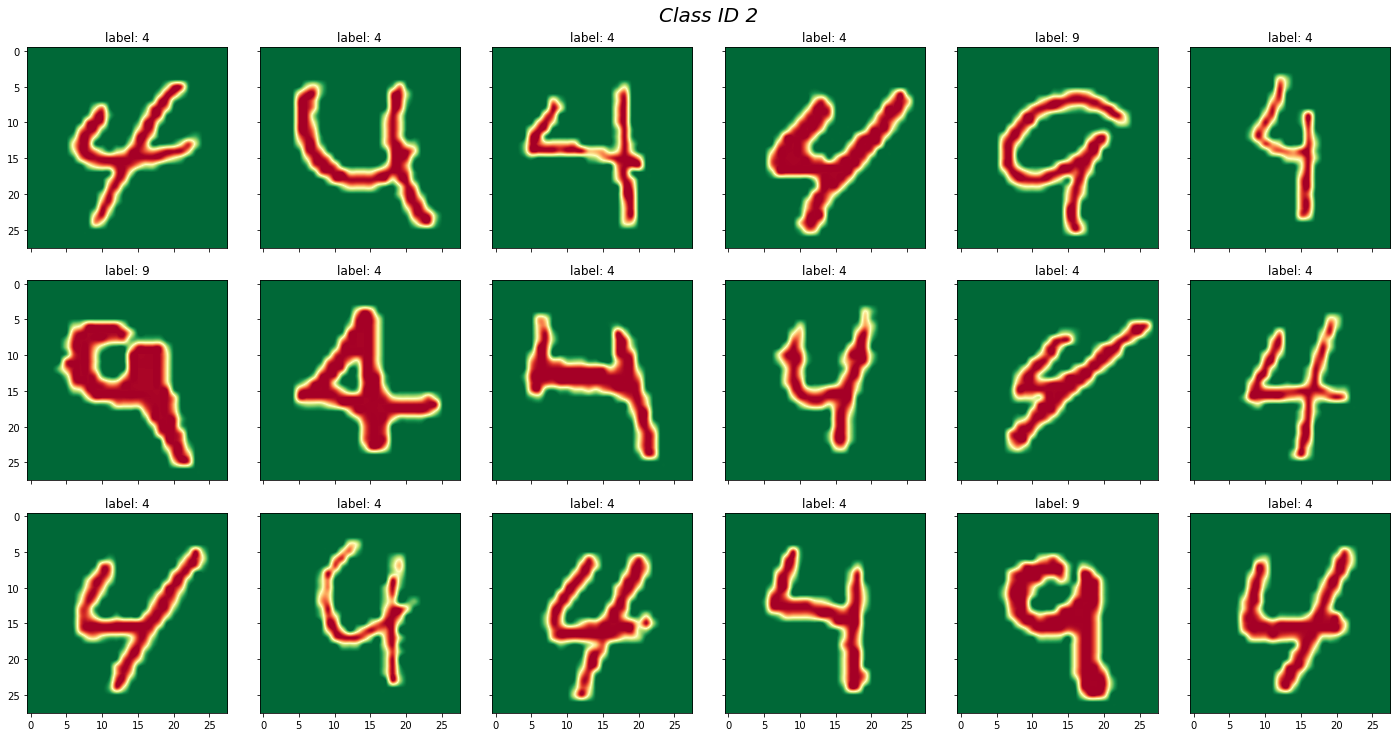

total samples: 18 / 7213


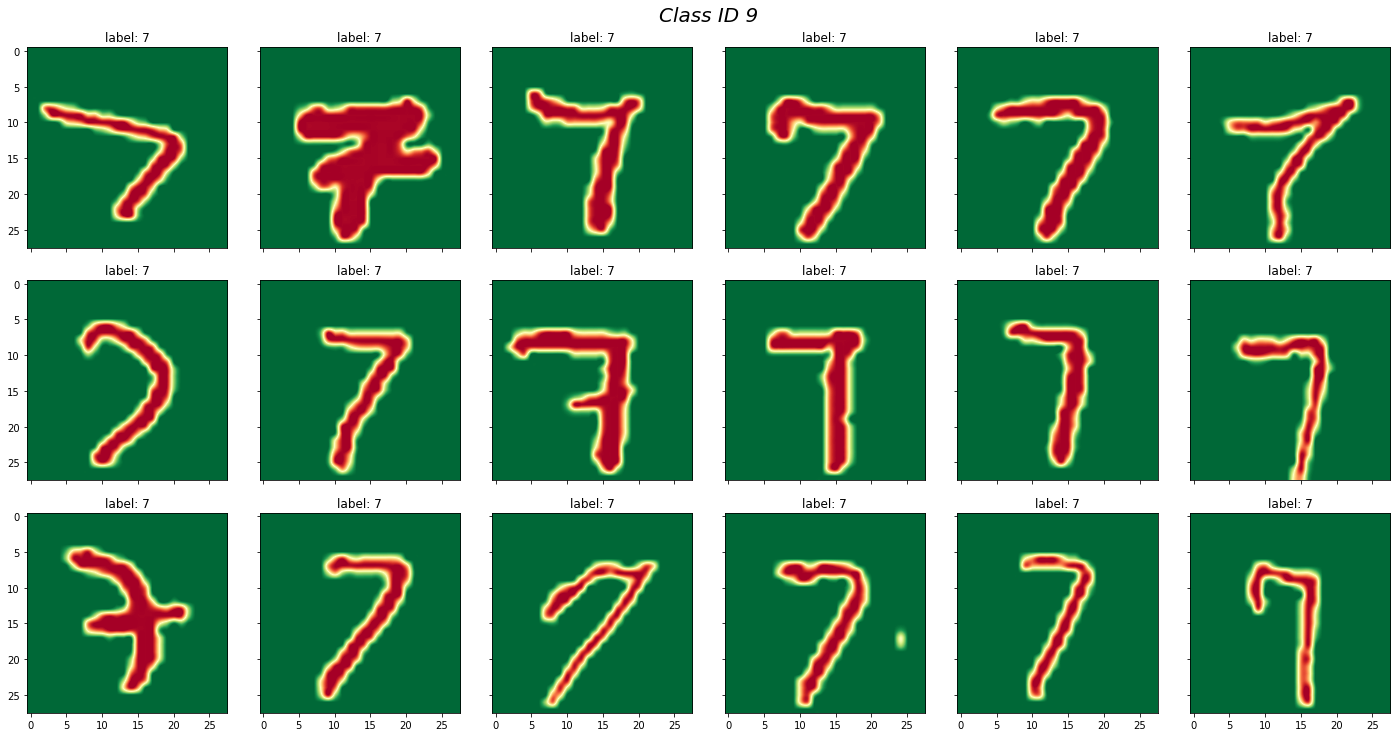

total samples: 18 / 7006


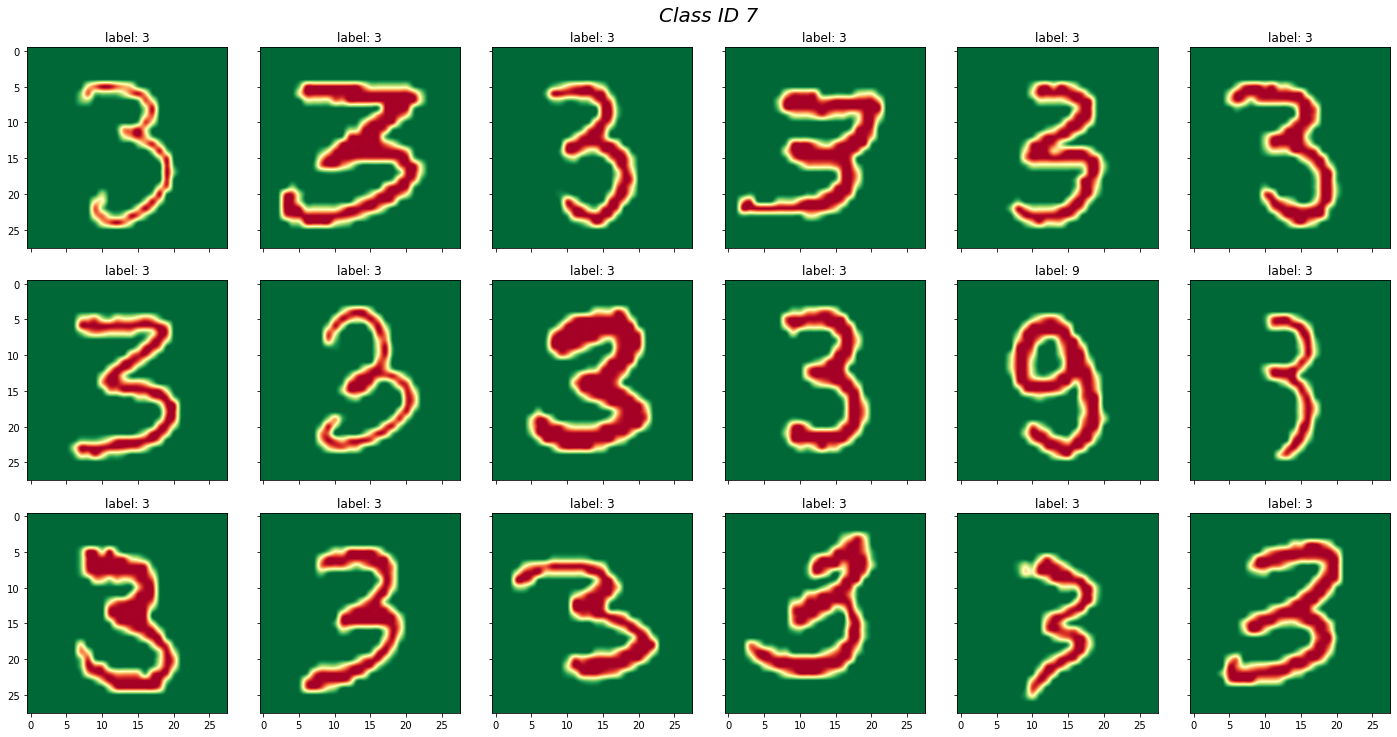

total samples: 18 / 6880


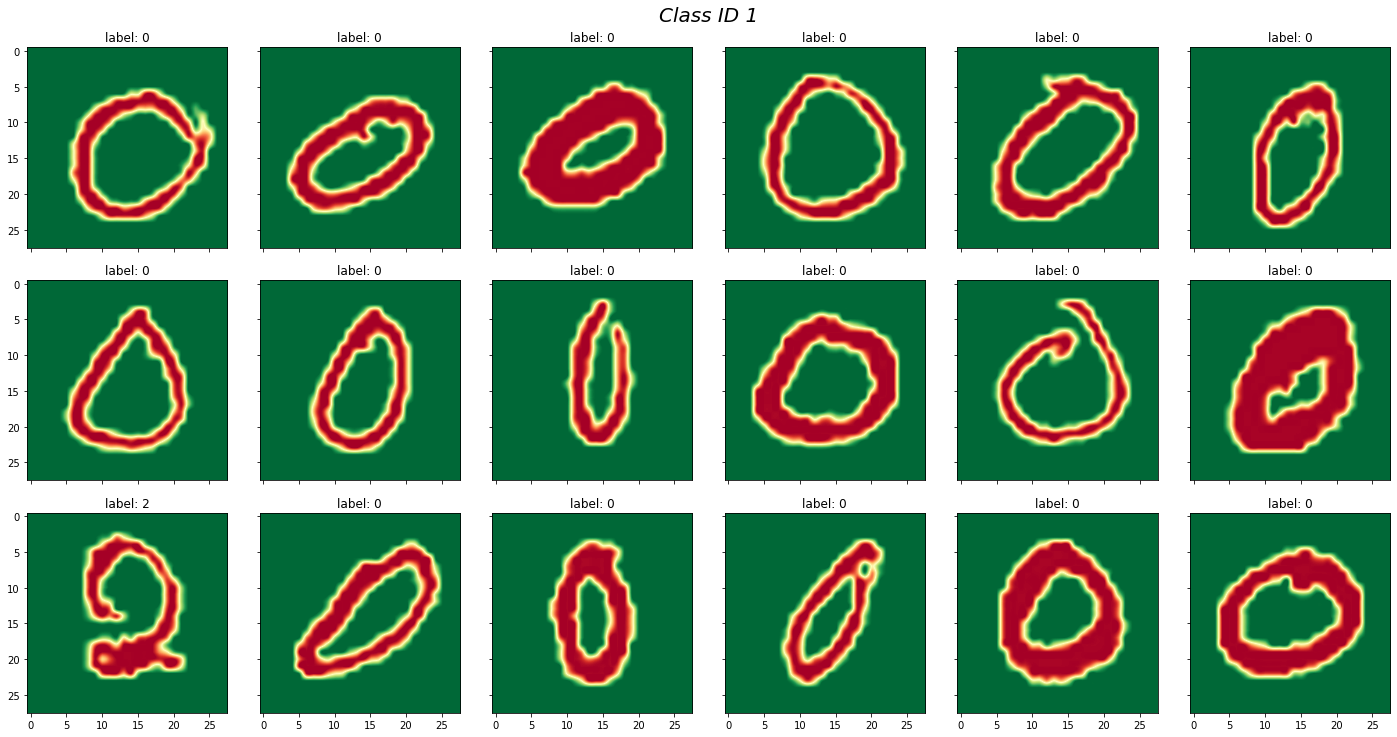

total samples: 18 / 6873


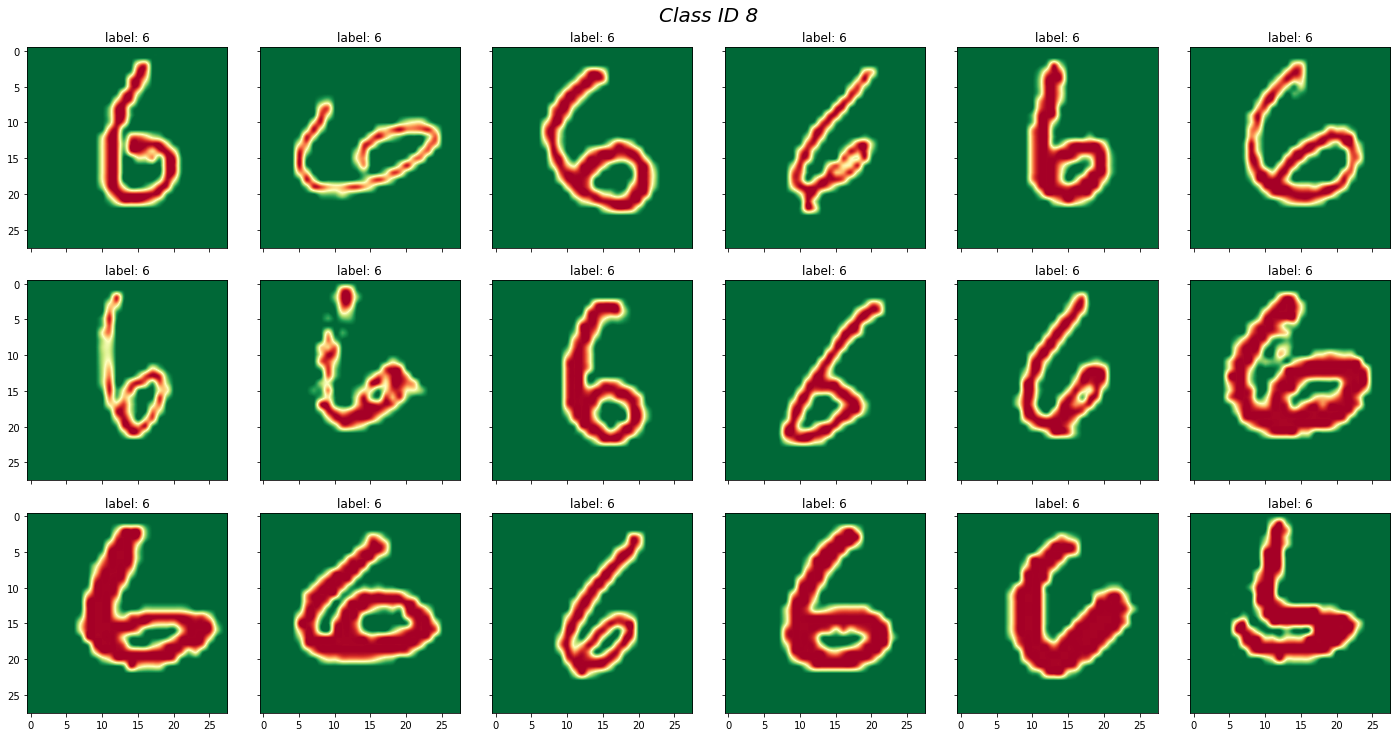

total samples: 18 / 6793


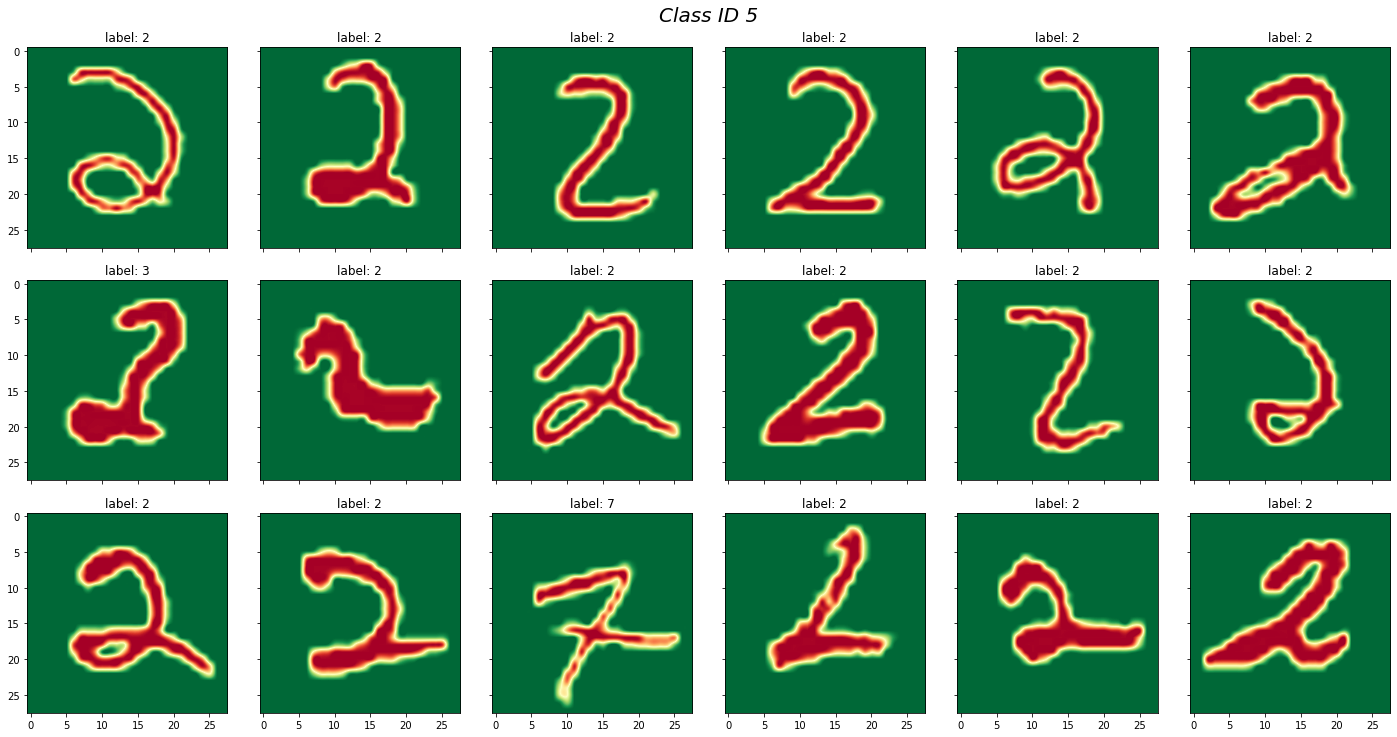

total samples: 18 / 6015


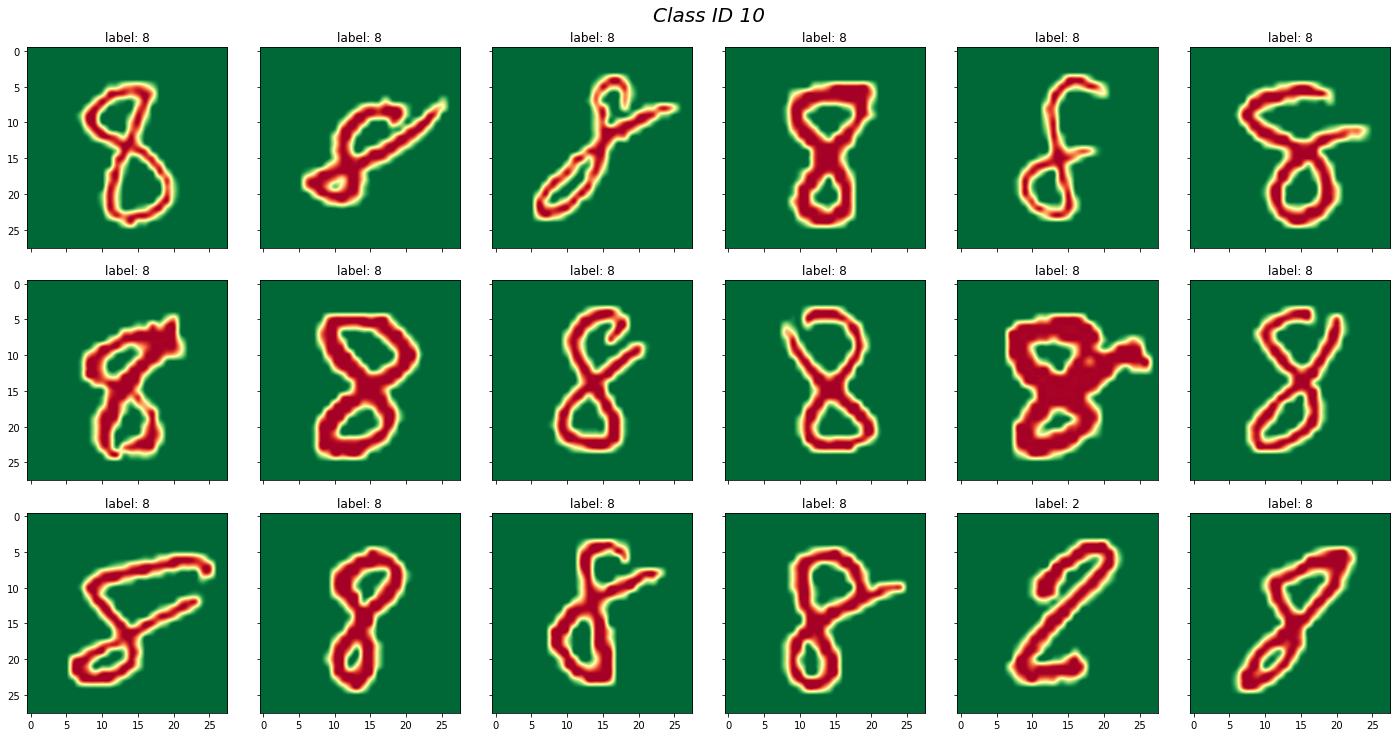

total samples: 18 / 4381


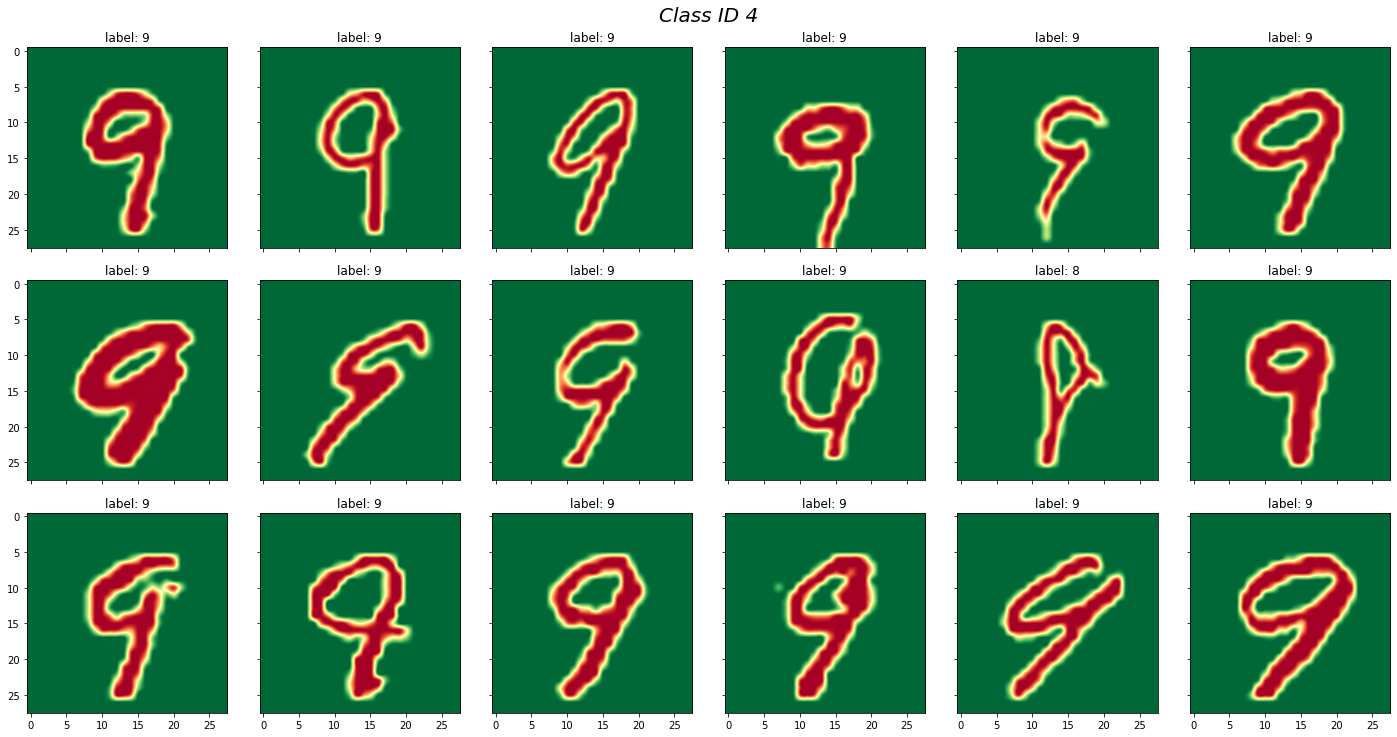

total samples: 18 / 4293


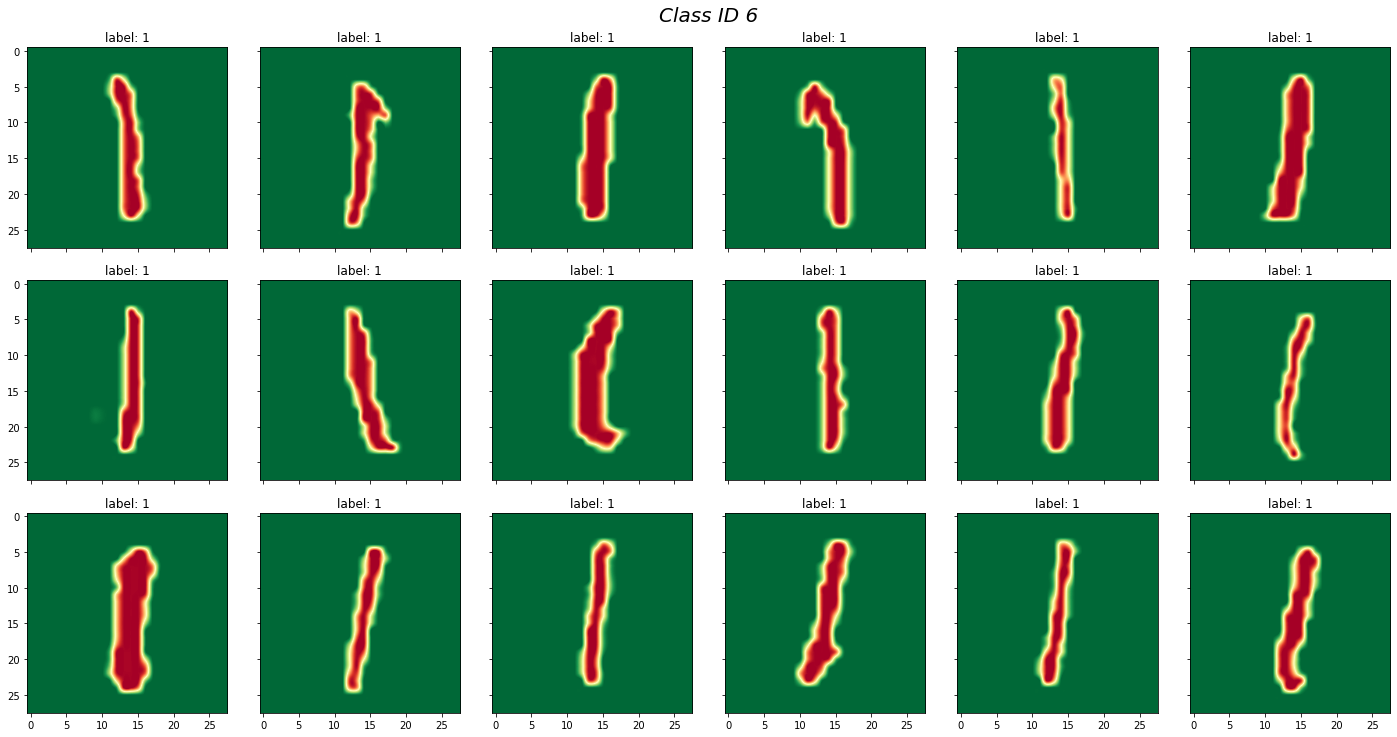

total samples: 18 / 3697


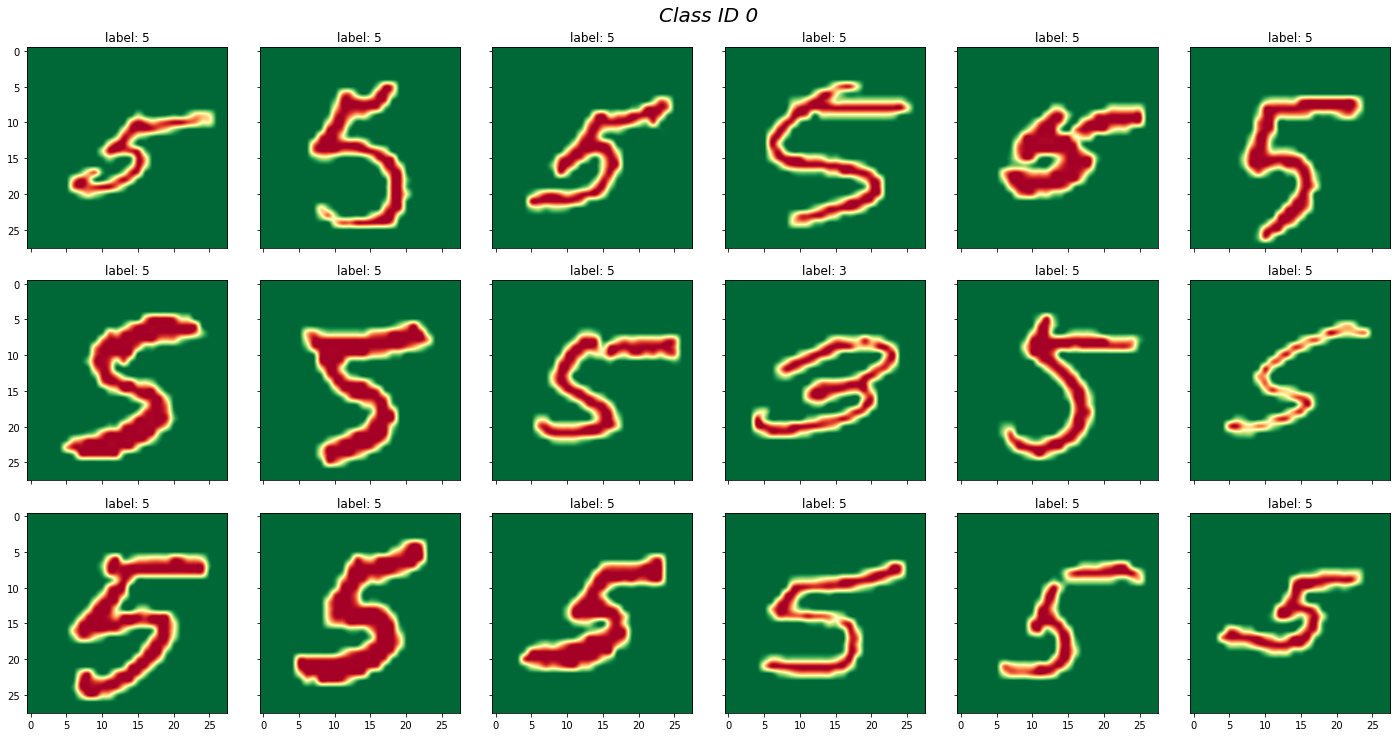

In [36]:
# default parameter values
def_vals = {'X' : None, 
            'arr_mse': None, 
            'arr_labels': None,
            'category': 'my_class', 
            'set_random': True,
            'nrows' : 3, 
            'ncols' :6
           }
# update dictionary key value

selcted_clusters = lst_top_classes
# selcted_clusters = np.unique(arr_label)
for cluster_id in selcted_clusters:
    class_indx = np.where(y_pred == cluster_id)[0]
    def_vals['X'] = X_2d[class_indx]
    def_vals['arr_labels'] = y_gt[class_indx]
    def_vals['category'] = cluster_id
    dk.mgcMultiHeat(**def_vals)

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


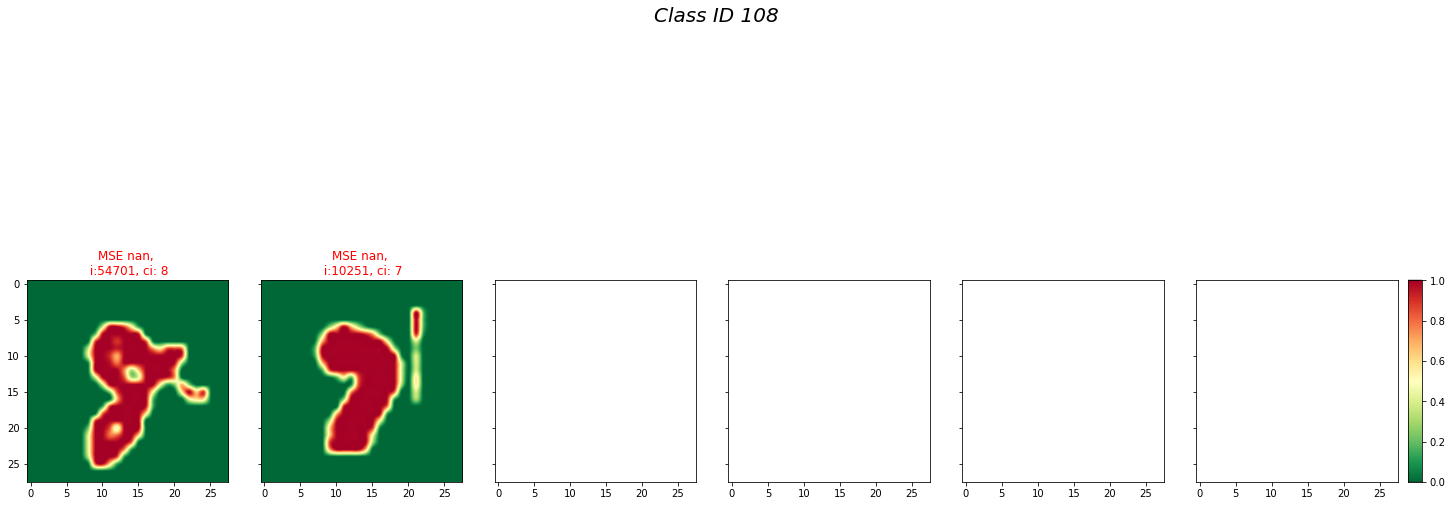

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


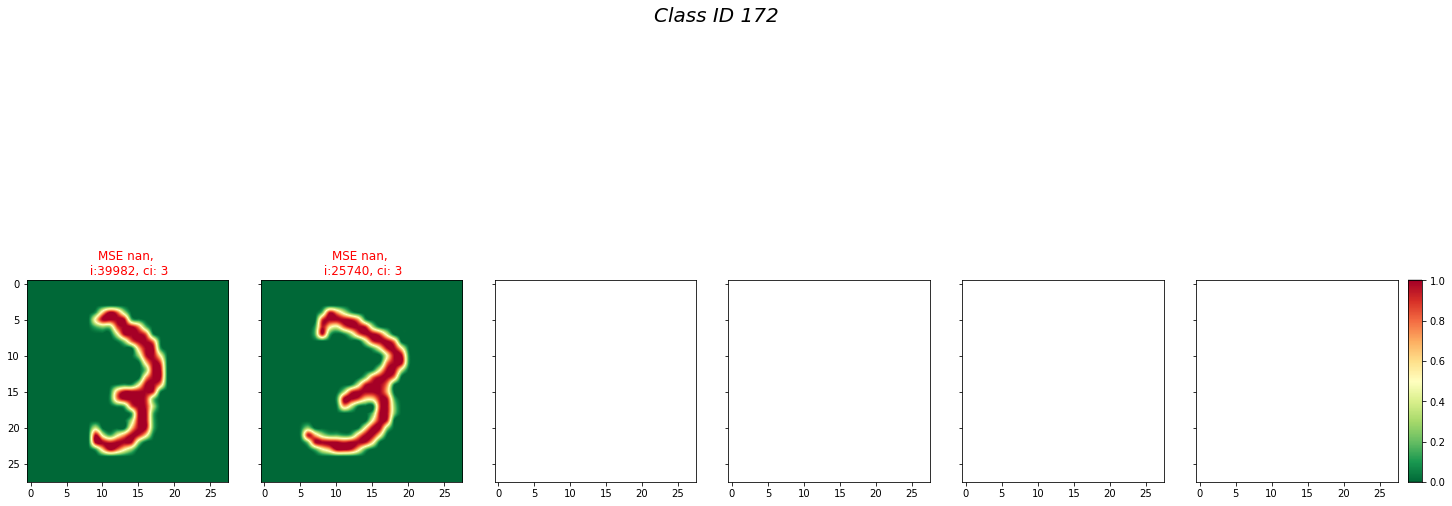

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


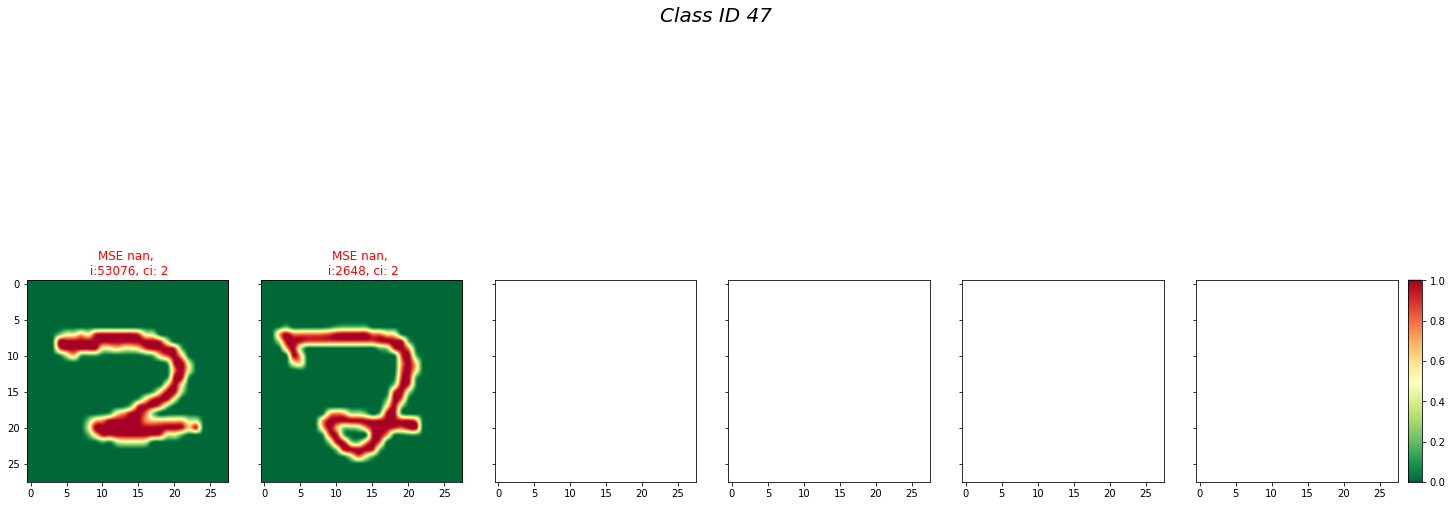

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


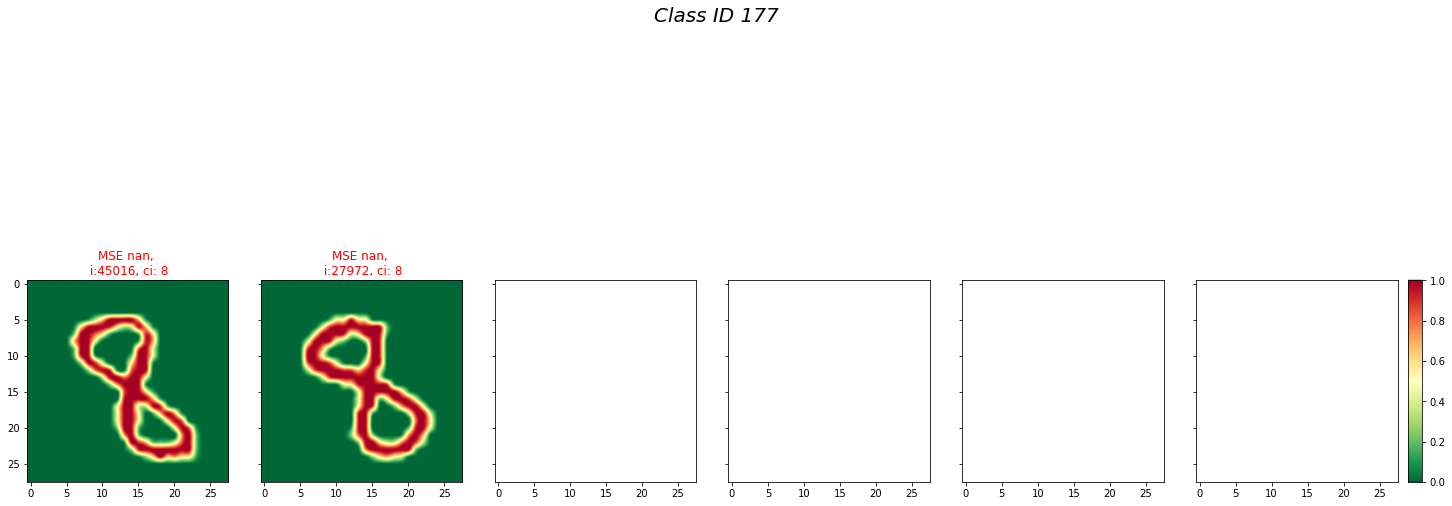

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


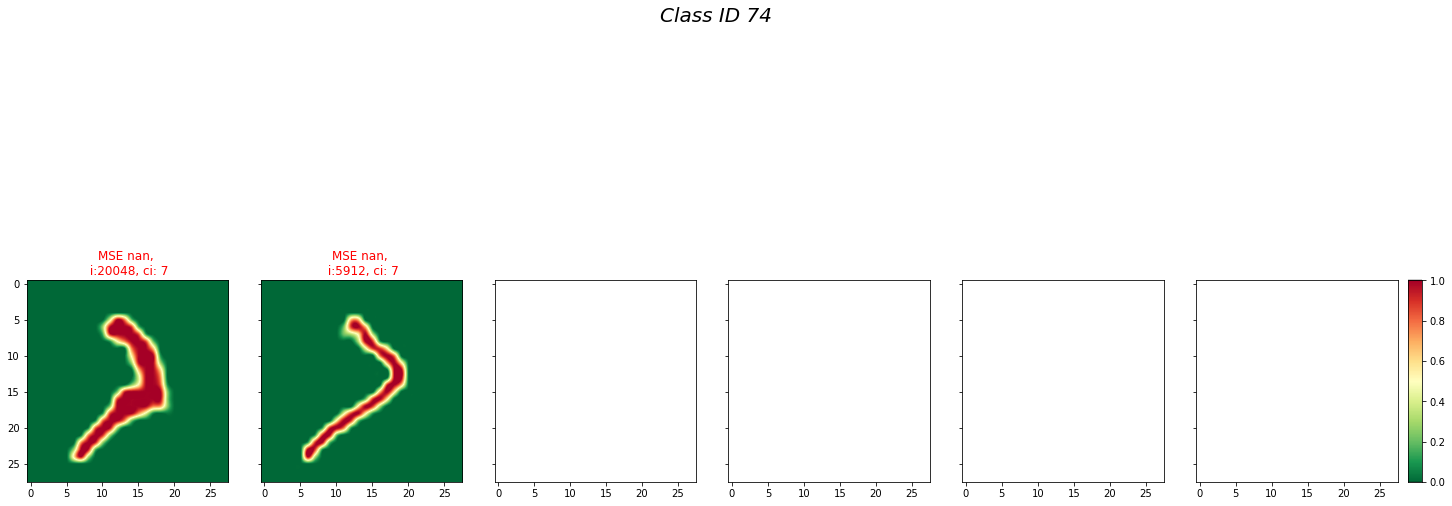

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


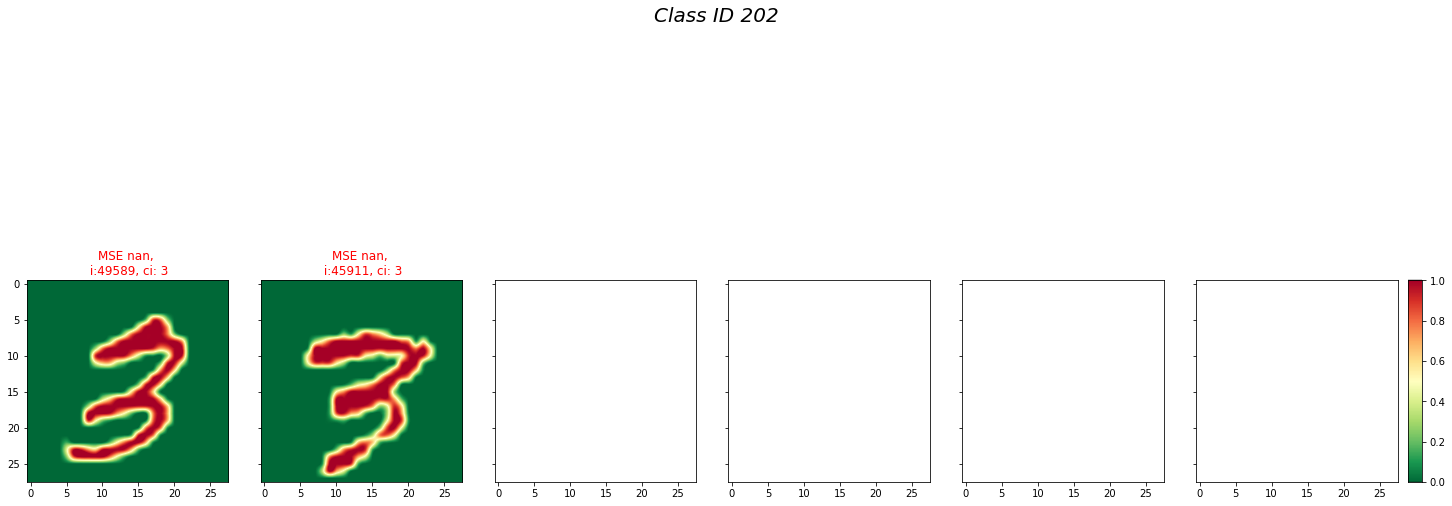

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


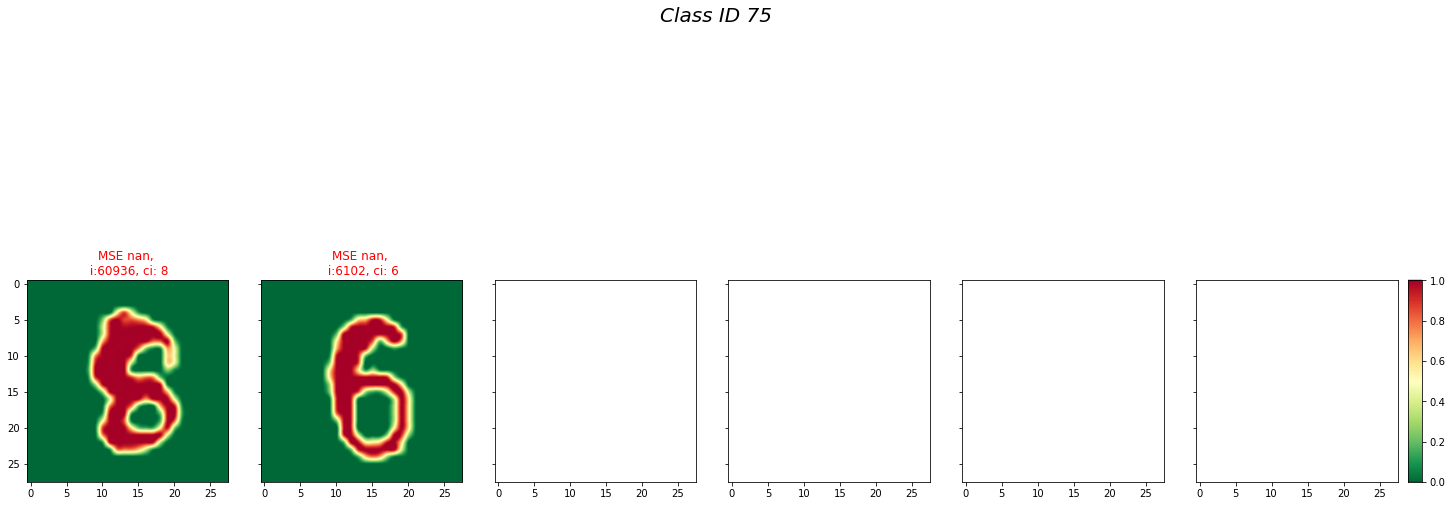

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


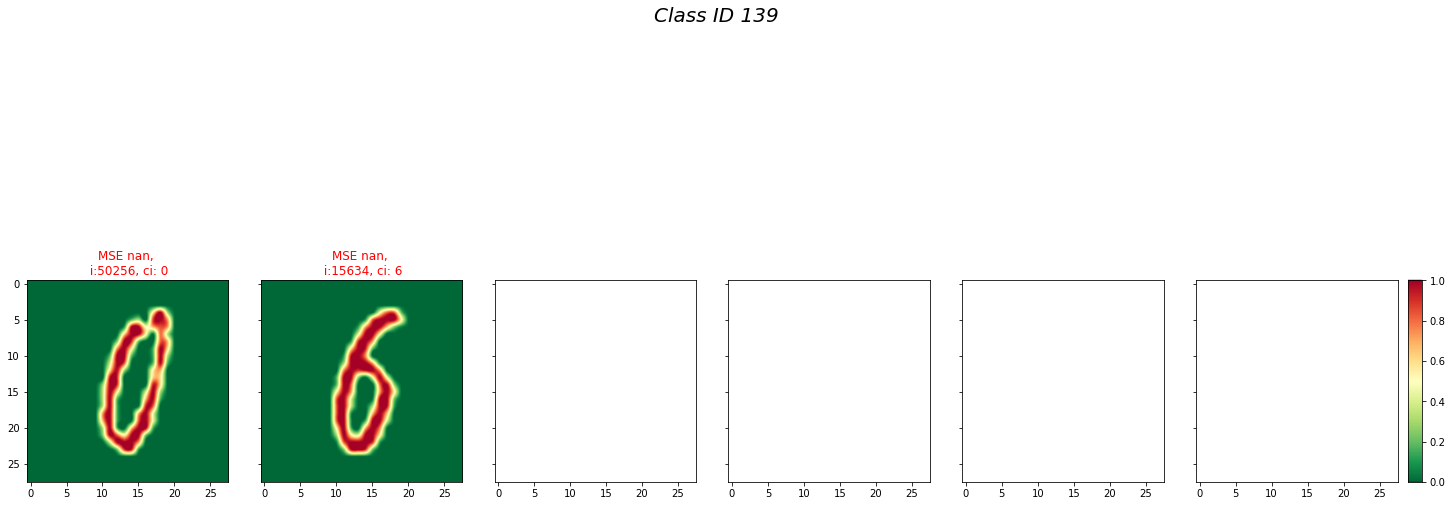

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


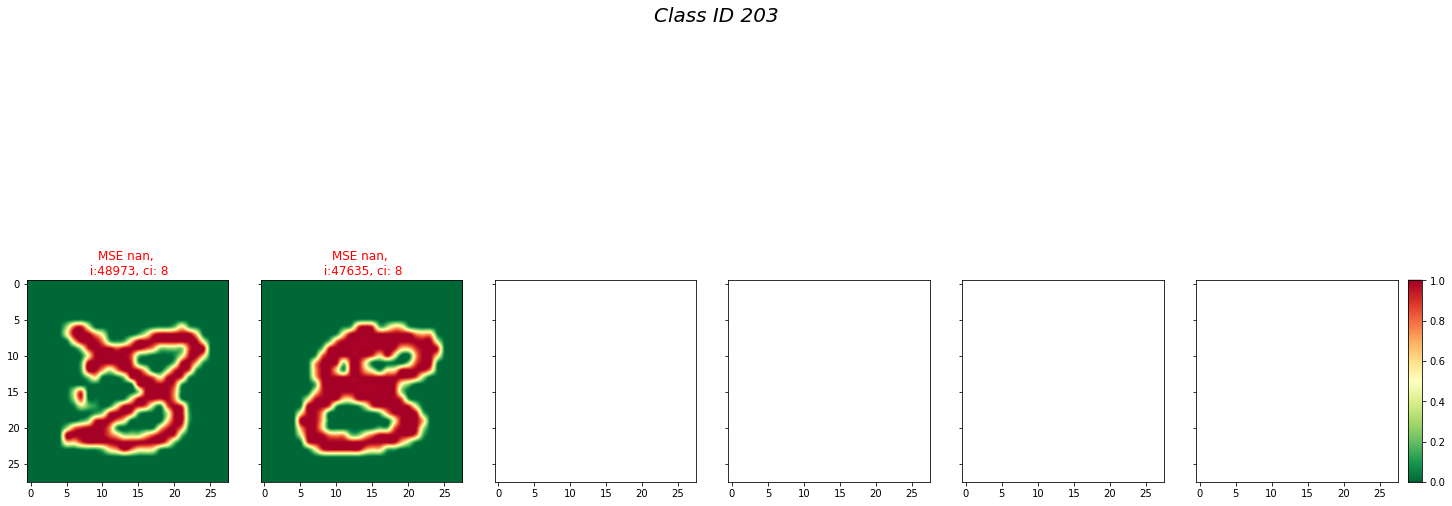

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


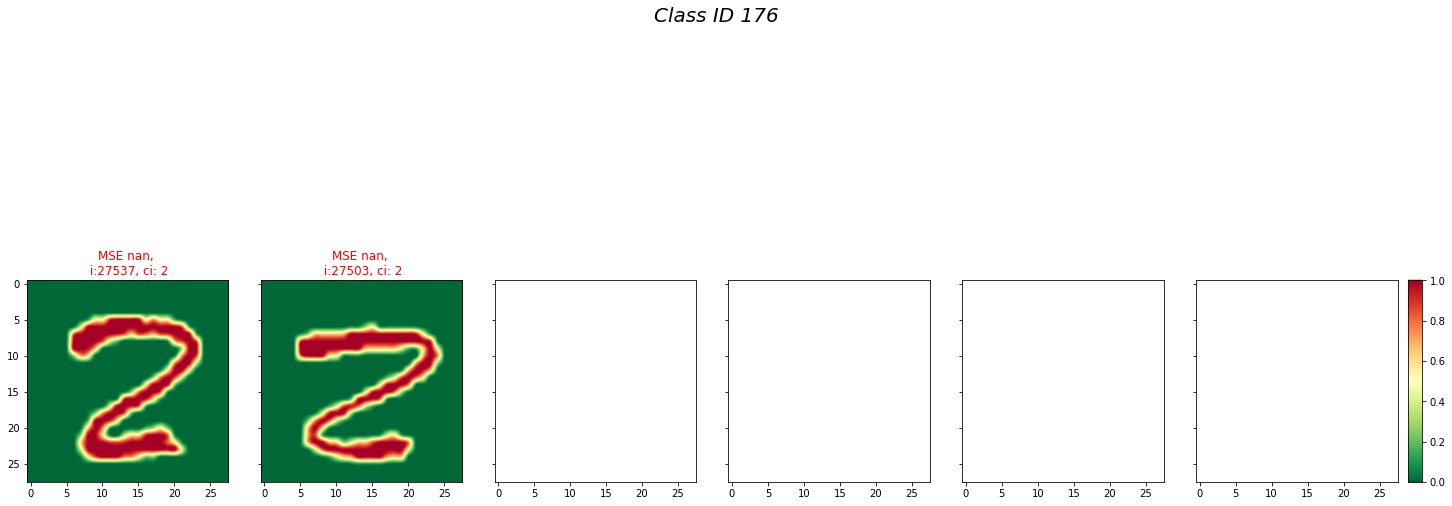

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


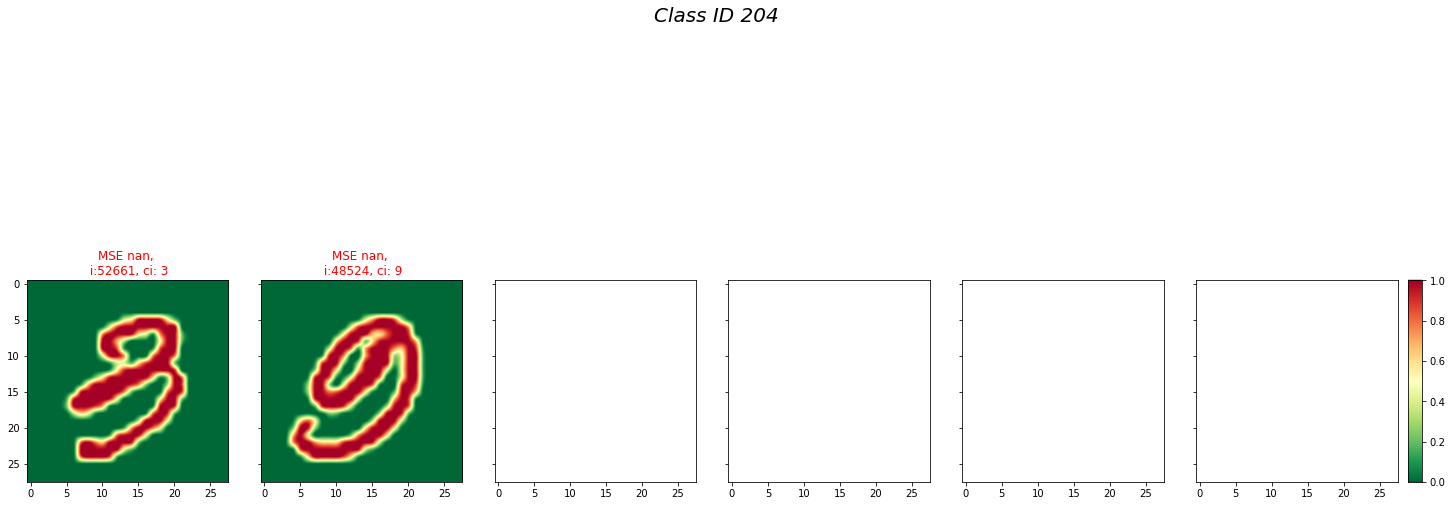

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


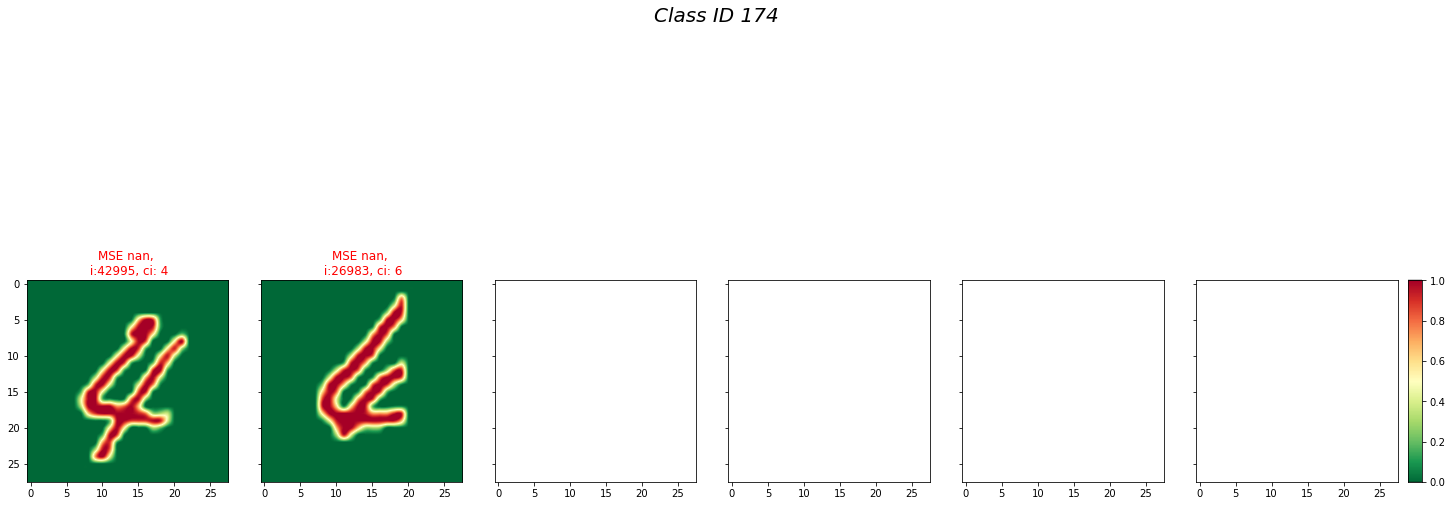

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


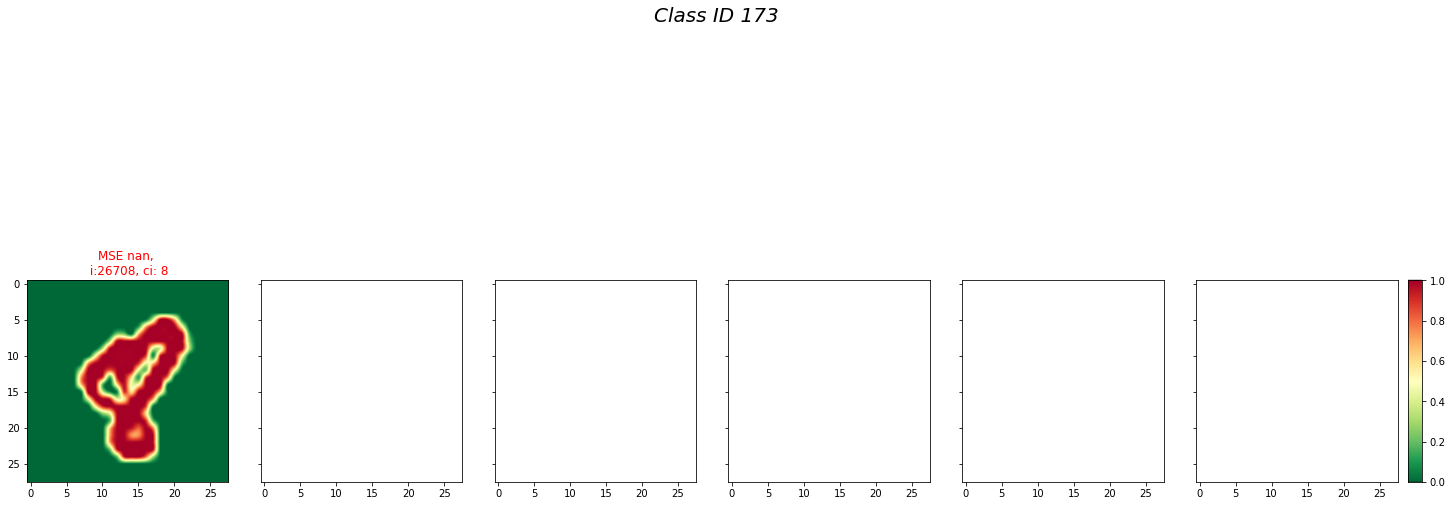

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


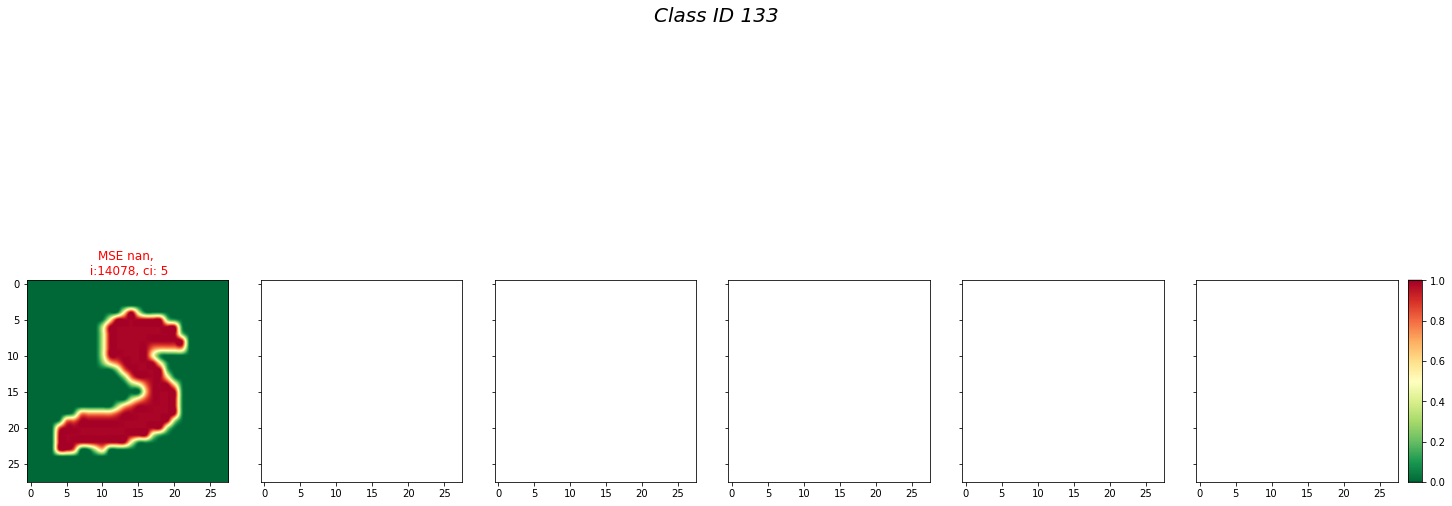

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


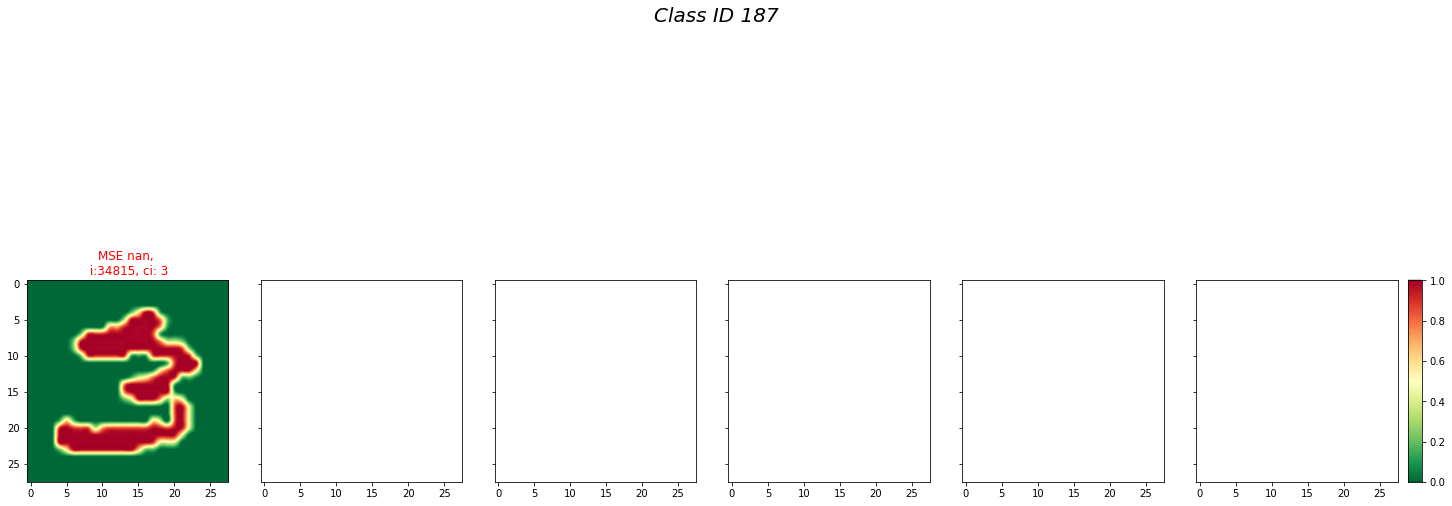

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


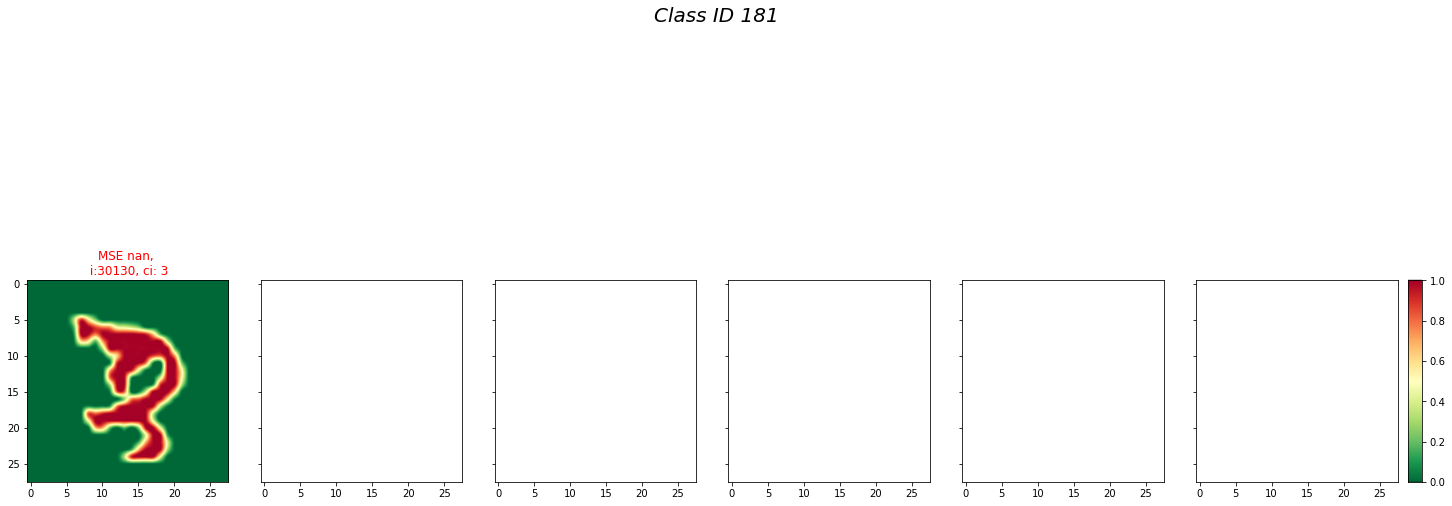

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


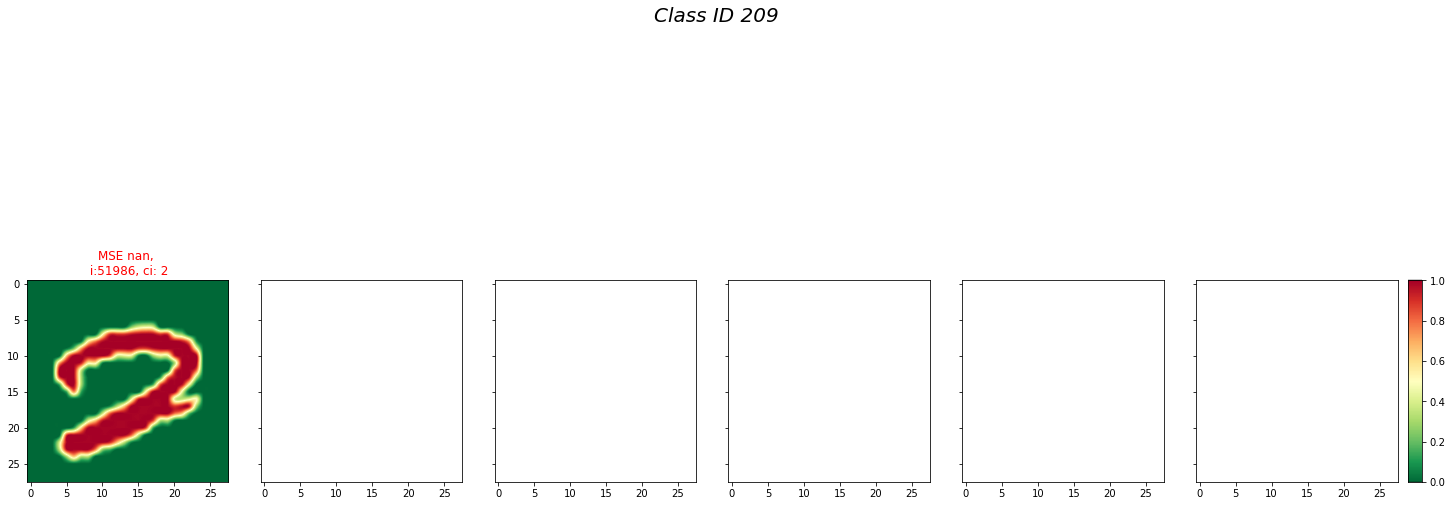

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


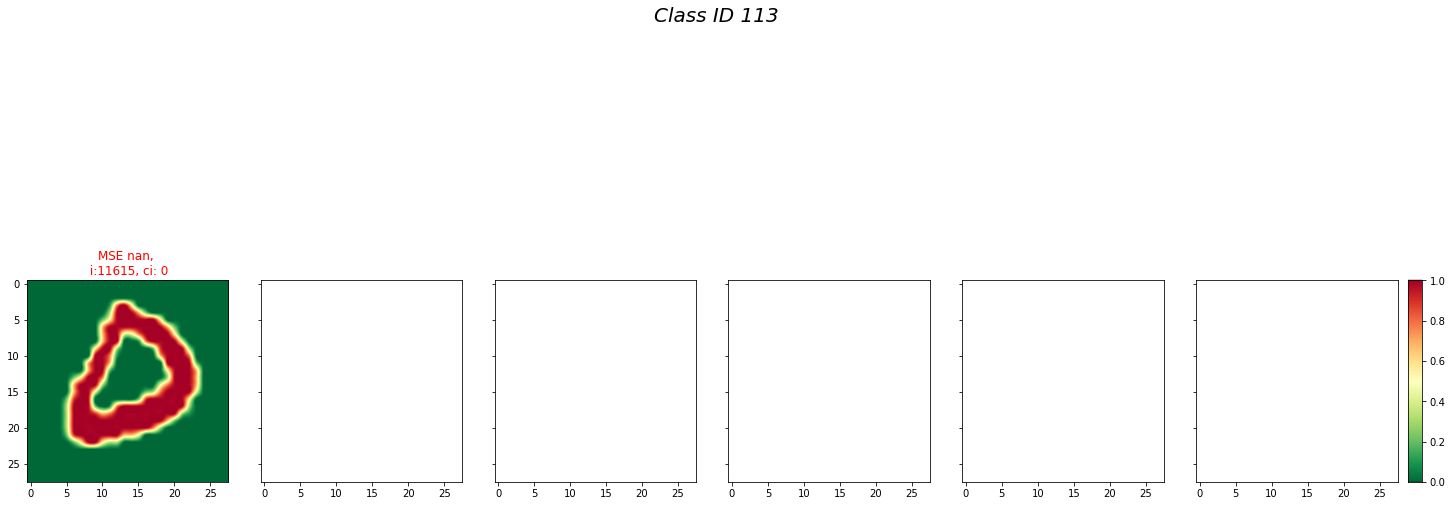

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


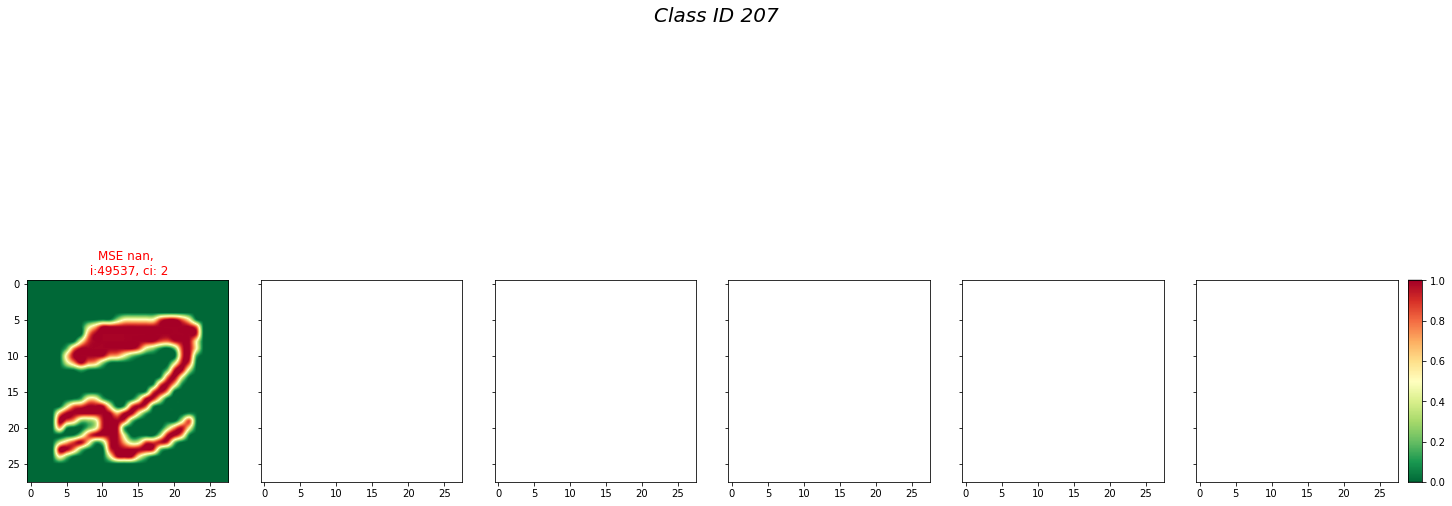

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


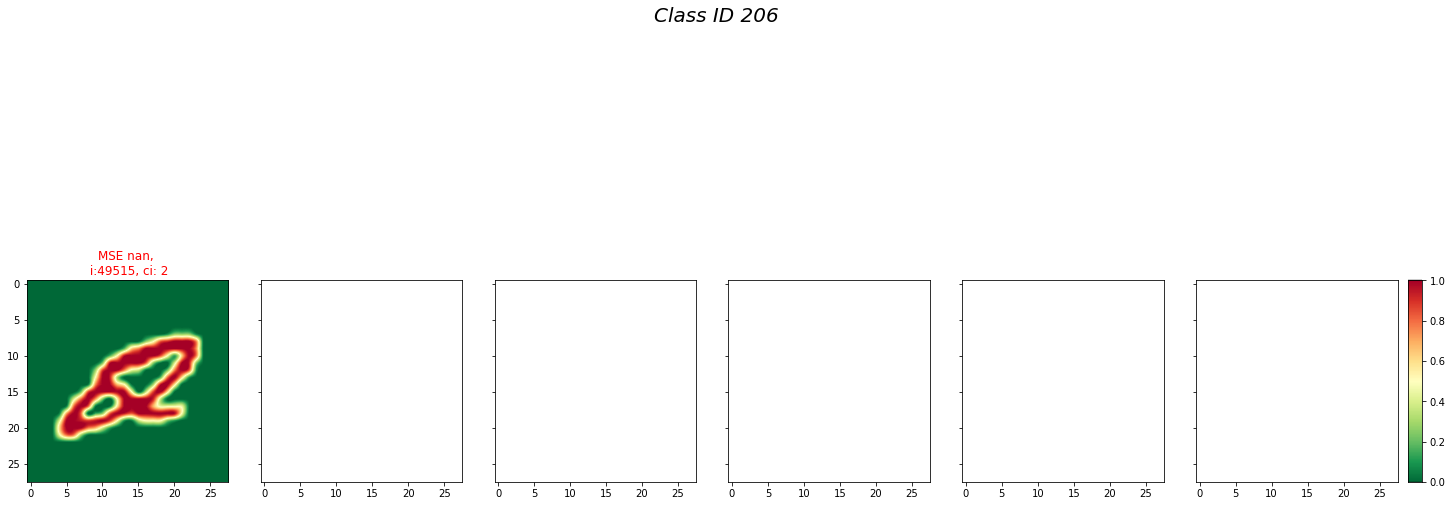

In [162]:
# default parameter values
def_vals = {'x_train' : X_2d, 
            'arr_mse': None, 
            'arr_mse_indx': None, 
            'cell_id': y_gt,
            'label_class': 'my_class', 
            'set_random': True,
            'rowx' : 3, 
            'colx' :6, 
            'img_rows' : 25, 
            'img_cols': 24, 
            'fname': 'plt_heat'}
# update dictionary key value

selcted_clusters = lst_bottom_classes
# selcted_clusters = np.unique(arr_label)
for cluster_id in selcted_clusters:
    class_indx = np.where(y_pred == cluster_id)[0]
    
    def_vals['label_class'] = cluster_id
    def_vals['arr_mse_indx'] = class_indx
    mgcMultiHeat_mse2(**def_vals)